In [1]:
import os.path
import pickle
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.utils as vutils
from IPython.core.display import HTML
from matplotlib import animation
import matplotlib
from tqdm.auto import tqdm

matplotlib.rcParams['animation.embed_limit'] = 2**128
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch import nn
from torch import optim

based on [https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html#loss-functions-and-optimizers](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html#loss-functions-and-optimizers)

In [2]:
BATCH_SIZE = 256
IMG_SIZE = (64, 64)
IMG_CHANNELS = 3
LATENT_SPACE_DIM = 100
GENERATOR_FEATURES_SIZE = 64
DISCRIMINATOR_FEATURES_SIZE = 64
LEARNING_RATE = 0.0002
# Beta1 for Adam
BETA1 = 0.5
NUM_EPOCHS = 60
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.cuda.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Random Seed:  999


In [3]:
dataset = datasets.ImageFolder("lsun_bedroom", transform=transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)
len(dataset), len(loader)

(303125, 1185)

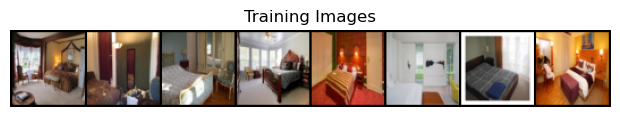

In [4]:
batch = next(iter(loader))
plt.figure(figsize=(8,1))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:8], padding=2, normalize=True).cpu(),(1,2,0)))

In [5]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self, latent_space_dim):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(latent_space_dim, GENERATOR_FEATURES_SIZE * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(GENERATOR_FEATURES_SIZE * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(GENERATOR_FEATURES_SIZE * 8, GENERATOR_FEATURES_SIZE * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(GENERATOR_FEATURES_SIZE * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( GENERATOR_FEATURES_SIZE * 4, GENERATOR_FEATURES_SIZE * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(GENERATOR_FEATURES_SIZE * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( GENERATOR_FEATURES_SIZE * 2, GENERATOR_FEATURES_SIZE, 4, 2, 1, bias=False),
            nn.BatchNorm2d(GENERATOR_FEATURES_SIZE),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( GENERATOR_FEATURES_SIZE, IMG_CHANNELS, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(IMG_CHANNELS, DISCRIMINATOR_FEATURES_SIZE, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(DISCRIMINATOR_FEATURES_SIZE, DISCRIMINATOR_FEATURES_SIZE * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(DISCRIMINATOR_FEATURES_SIZE * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(DISCRIMINATOR_FEATURES_SIZE * 2, DISCRIMINATOR_FEATURES_SIZE * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(DISCRIMINATOR_FEATURES_SIZE * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(DISCRIMINATOR_FEATURES_SIZE * 4, DISCRIMINATOR_FEATURES_SIZE * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(DISCRIMINATOR_FEATURES_SIZE * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(DISCRIMINATOR_FEATURES_SIZE * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [6]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()


# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

In [7]:
def fit_gan(netG, netD, optimizerG, optimizerD, num_epochs, criterion, fixed_noise, latent_dim):

    # Lists to keep track of progress
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0

    print("Starting Training Loop...")
    # For each epoch
    for epoch in tqdm(range(num_epochs)):
        # For each batch in the dataloader
        for i, data in enumerate(loader, 0):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, latent_dim, 1, 1, device=device)
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(loader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(loader) - 1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1

    return {
        'generator': netG,
        'discriminator': netD,
        'images': img_list,
        'D_losses': D_losses,
        'G_losses': G_losses
    }

In [8]:
def save_models(results_dict, path):
    torch.save(results_dict["generator"].state_dict(), os.path.join(path, 'generator'))
    torch.save(results_dict["discriminator"].state_dict(), os.path.join(path, 'discriminator'))

def save_images(results_dict, path):
    with open(os.path.join(path, "images.pkl"), "wb") as f:
        pickle.dump(results_dict['images'], f)

def save_losses(results_dict, path):
    with open(os.path.join(path, "loss_D.pkl"), "wb") as f:
        pickle.dump(results_dict['D_losses'], f)
    with open(os.path.join(path, "loss_G.pkl"), "wb") as f:
        pickle.dump(results_dict['G_losses'], f)

In [9]:
latent_dims = [32, 128, 1024]

for latent_dim in latent_dims:
    netG = Generator(latent_dim).to(device)
    netD = Discriminator().to(device)

    # Apply the ``weights_init`` function to randomly initialize all weights
    #  to ``mean=0``, ``stdev=0.02``.
    netG.apply(weights_init)
    netD.apply(weights_init)
    # Setup Adam optimizers for both G and D
    optimizerD = optim.Adam(netD.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))
    # Create batch of latent vectors that we will use to visualize
    #  the progression of the generator
    fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)
    print(f"Started training for latent space dimension = {latent_dim}")
    results = fit_gan(netG, netD, optimizerG, optimizerD, NUM_EPOCHS, criterion, fixed_noise, latent_dim)
    path_to_save = os.path.join("GANs", f"DC-GAN_{latent_dim}")
    if not os.path.exists(path_to_save):
        os.makedirs(path_to_save, exist_ok=True)
    save_models(results, path_to_save)
    save_images(results, path_to_save)
    save_losses(results, path_to_save)

Started training for latent space dimension = 32
Starting Training Loop...


  0%|          | 0/60 [00:00<?, ?it/s]

[0/60][0/1185]	Loss_D: 1.7497	Loss_G: 5.6562	D(x): 0.4641	D(G(z)): 0.4999 / 0.0076
[0/60][50/1185]	Loss_D: 1.9889	Loss_G: 12.9984	D(x): 0.9575	D(G(z)): 0.8027 / 0.0000
[0/60][100/1185]	Loss_D: 0.7469	Loss_G: 5.2808	D(x): 0.7789	D(G(z)): 0.3232 / 0.0091
[0/60][150/1185]	Loss_D: 1.3438	Loss_G: 14.0107	D(x): 0.9464	D(G(z)): 0.6016 / 0.0000
[0/60][200/1185]	Loss_D: 0.7669	Loss_G: 3.4390	D(x): 0.6593	D(G(z)): 0.1793 / 0.0498
[0/60][250/1185]	Loss_D: 0.8832	Loss_G: 5.1496	D(x): 0.8124	D(G(z)): 0.4237 / 0.0084
[0/60][300/1185]	Loss_D: 0.5659	Loss_G: 3.8734	D(x): 0.7617	D(G(z)): 0.1803 / 0.0300
[0/60][350/1185]	Loss_D: 0.6545	Loss_G: 6.0945	D(x): 0.8264	D(G(z)): 0.3339 / 0.0037
[0/60][400/1185]	Loss_D: 0.5394	Loss_G: 6.8292	D(x): 0.8814	D(G(z)): 0.2919 / 0.0018
[0/60][450/1185]	Loss_D: 0.5178	Loss_G: 3.8628	D(x): 0.7935	D(G(z)): 0.1793 / 0.0362
[0/60][500/1185]	Loss_D: 0.9842	Loss_G: 2.9947	D(x): 0.5149	D(G(z)): 0.0151 / 0.0959
[0/60][550/1185]	Loss_D: 0.2258	Loss_G: 2.6951	D(x): 0.8458	D(G(z)

  0%|          | 0/60 [00:00<?, ?it/s]

[0/60][0/1185]	Loss_D: 1.6324	Loss_G: 6.2730	D(x): 0.5265	D(G(z)): 0.5097 / 0.0033
[0/60][50/1185]	Loss_D: 0.5092	Loss_G: 23.1011	D(x): 0.7178	D(G(z)): 0.0000 / 0.0000
[0/60][100/1185]	Loss_D: 0.9976	Loss_G: 4.9694	D(x): 0.9674	D(G(z)): 0.5559 / 0.0200
[0/60][150/1185]	Loss_D: 0.4648	Loss_G: 5.7996	D(x): 0.8334	D(G(z)): 0.1942 / 0.0043
[0/60][200/1185]	Loss_D: 0.1409	Loss_G: 4.8709	D(x): 0.9321	D(G(z)): 0.0485 / 0.0119
[0/60][250/1185]	Loss_D: 0.2383	Loss_G: 4.9760	D(x): 0.8935	D(G(z)): 0.0659 / 0.0096
[0/60][300/1185]	Loss_D: 1.2392	Loss_G: 5.3799	D(x): 0.9254	D(G(z)): 0.5851 / 0.0107
[0/60][350/1185]	Loss_D: 0.7339	Loss_G: 2.2656	D(x): 0.7752	D(G(z)): 0.2733 / 0.1706
[0/60][400/1185]	Loss_D: 0.7132	Loss_G: 2.4856	D(x): 0.7553	D(G(z)): 0.2689 / 0.1230
[0/60][450/1185]	Loss_D: 0.3052	Loss_G: 5.9230	D(x): 0.9150	D(G(z)): 0.1730 / 0.0043
[0/60][500/1185]	Loss_D: 0.1533	Loss_G: 5.9521	D(x): 0.8968	D(G(z)): 0.0297 / 0.0055
[0/60][550/1185]	Loss_D: 0.4133	Loss_G: 5.0920	D(x): 0.8539	D(G(z))

  0%|          | 0/60 [00:00<?, ?it/s]

[0/60][0/1185]	Loss_D: 1.7565	Loss_G: 3.6530	D(x): 0.3647	D(G(z)): 0.3889 / 0.0376
[0/60][50/1185]	Loss_D: 0.2919	Loss_G: 9.9948	D(x): 0.9495	D(G(z)): 0.1997 / 0.0001
[0/60][100/1185]	Loss_D: 0.1374	Loss_G: 8.0809	D(x): 0.9342	D(G(z)): 0.0002 / 0.0004
[0/60][150/1185]	Loss_D: 0.6534	Loss_G: 3.7281	D(x): 0.7117	D(G(z)): 0.1285 / 0.0363
[0/60][200/1185]	Loss_D: 0.4434	Loss_G: 4.3627	D(x): 0.8882	D(G(z)): 0.2485 / 0.0164
[0/60][250/1185]	Loss_D: 0.2097	Loss_G: 4.8307	D(x): 0.8896	D(G(z)): 0.0690 / 0.0109
[0/60][300/1185]	Loss_D: 0.1903	Loss_G: 5.4923	D(x): 0.8923	D(G(z)): 0.0283 / 0.0057
[0/60][350/1185]	Loss_D: 0.8023	Loss_G: 11.0996	D(x): 0.8499	D(G(z)): 0.3774 / 0.0000
[0/60][400/1185]	Loss_D: 0.3966	Loss_G: 4.6901	D(x): 0.8569	D(G(z)): 0.1798 / 0.0126
[0/60][450/1185]	Loss_D: 0.6026	Loss_G: 3.5833	D(x): 0.7274	D(G(z)): 0.1185 / 0.0548
[0/60][500/1185]	Loss_D: 0.3541	Loss_G: 3.1938	D(x): 0.8292	D(G(z)): 0.1023 / 0.0647
[0/60][550/1185]	Loss_D: 0.1495	Loss_G: 4.3198	D(x): 0.9288	D(G(z))

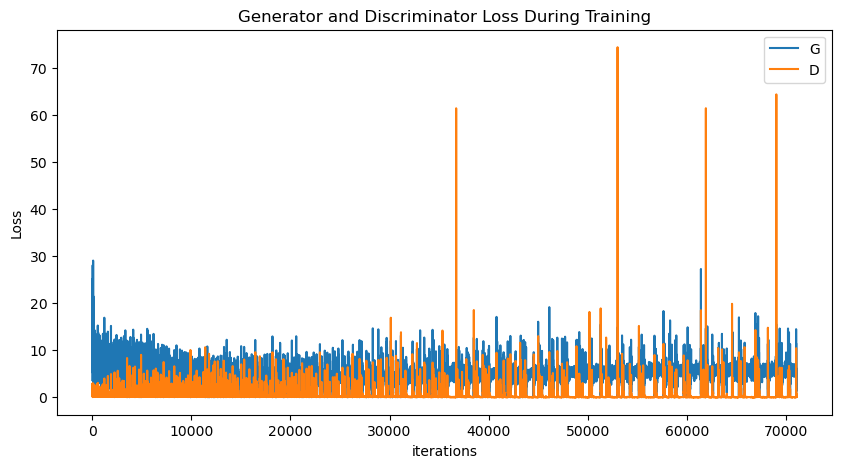

In [10]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(results["G_losses"],label="G")
plt.plot(results["D_losses"],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()